# Mini-batch Gradient Descent without Replacement

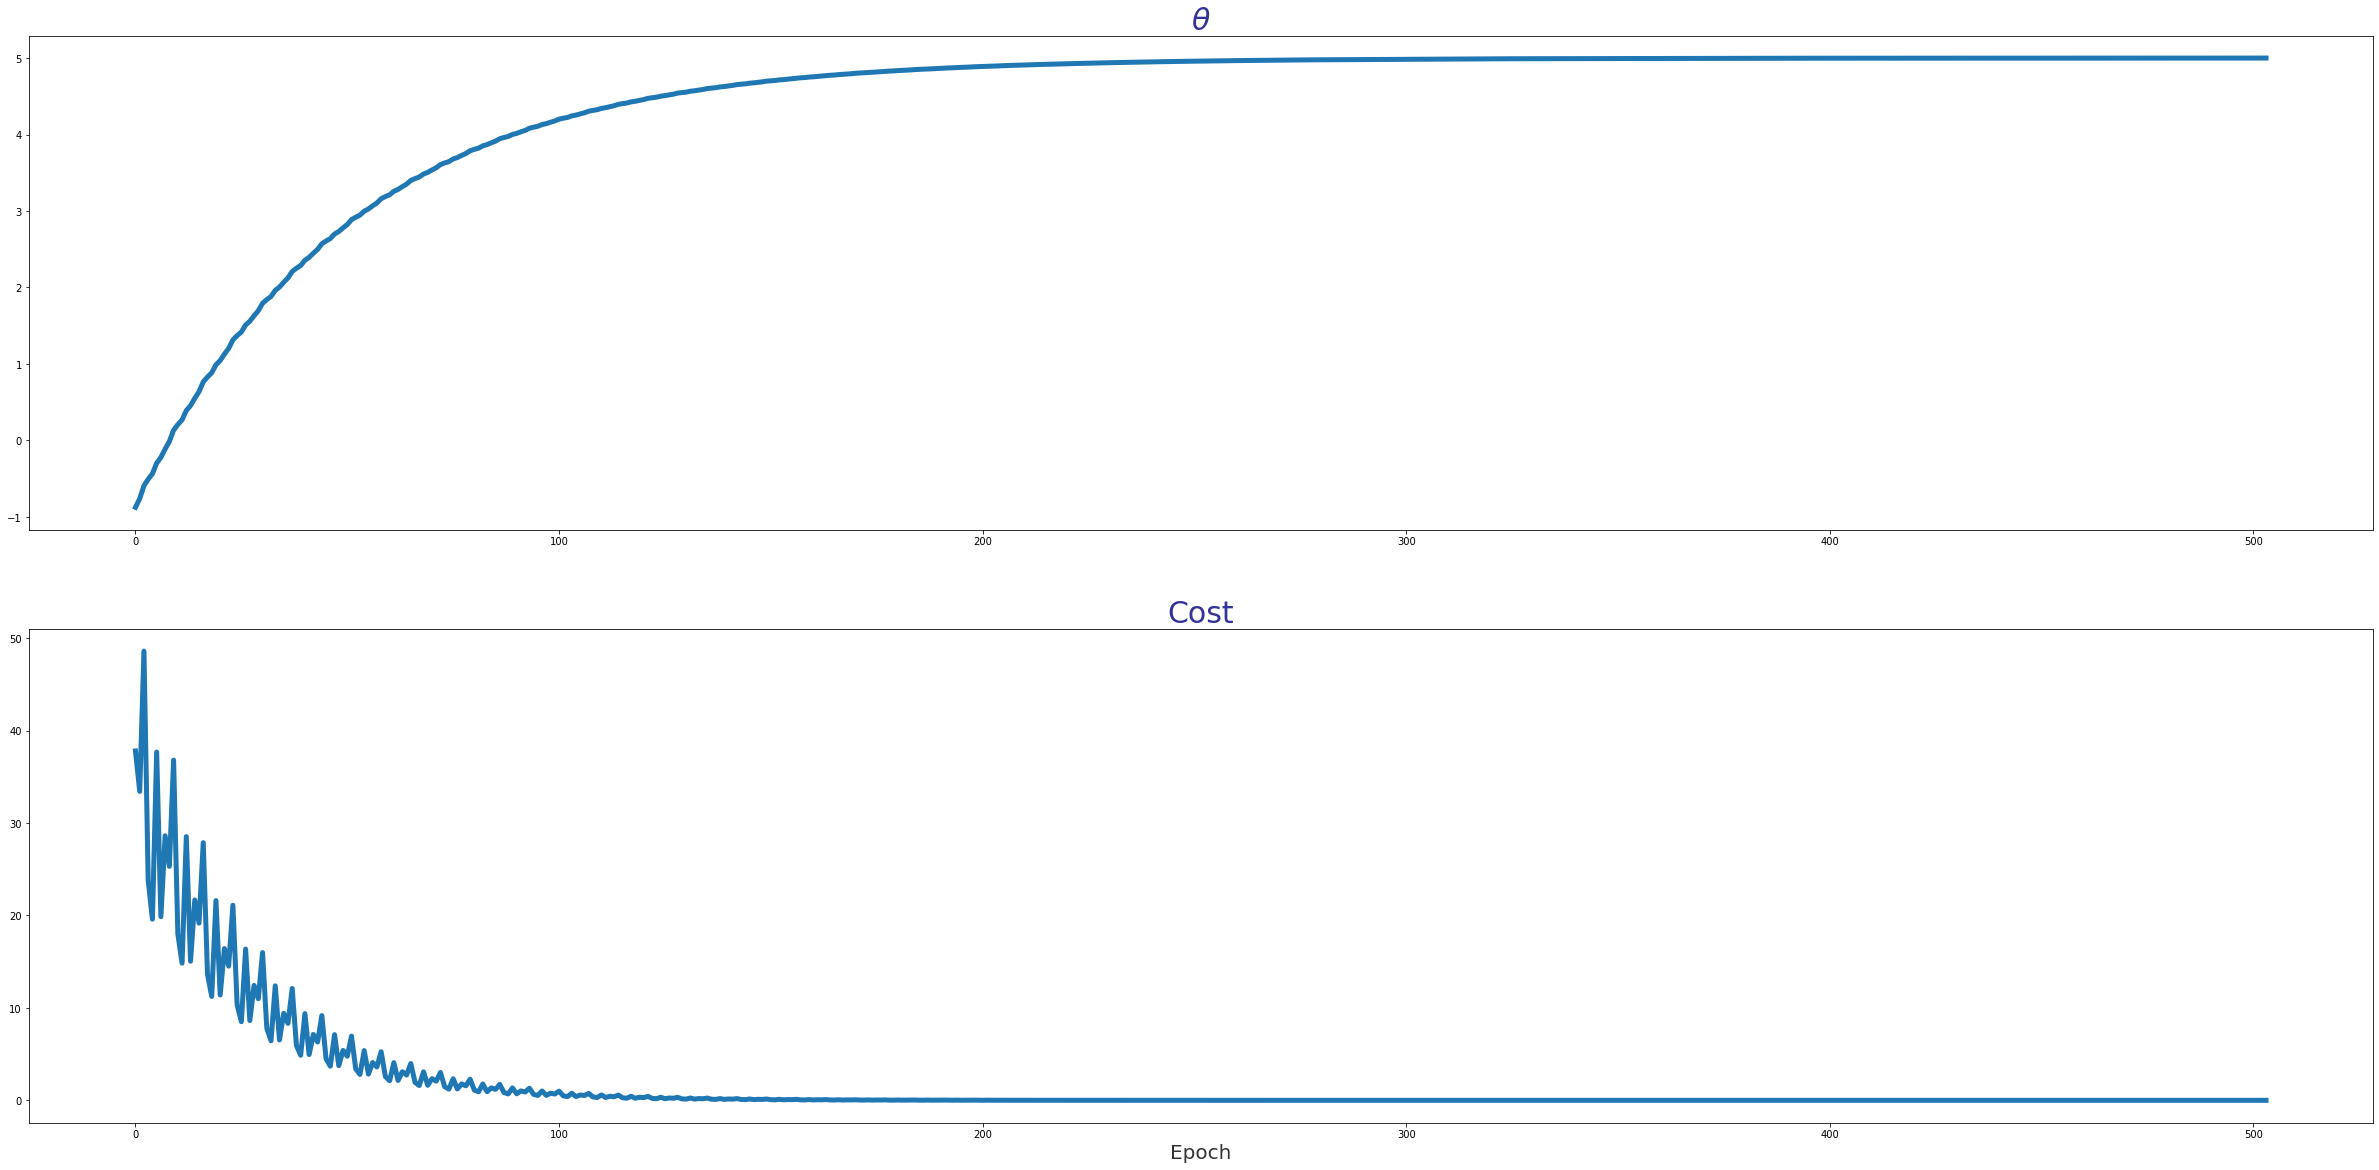

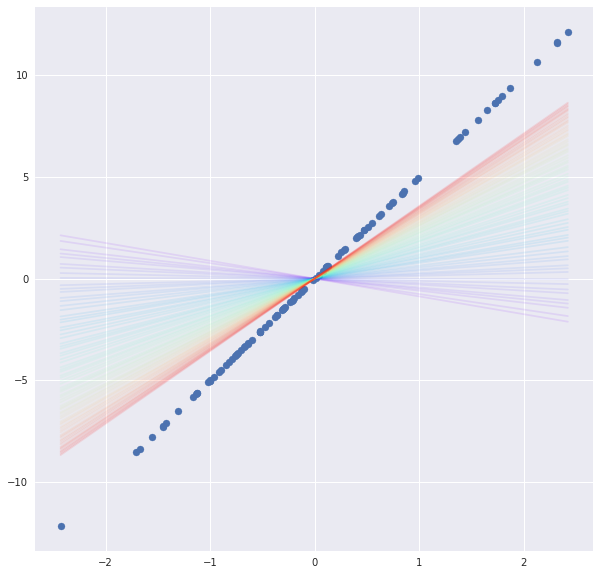

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class dataset_generator: 
    def __init__(self, feature_dim = 1, n_sample = 100, noise = 0):
        self._feature_dim = feature_dim
        self._n_sample = n_sample
        self._noise = noise
        
        self._coefficient = None
        self._init_set_coefficient()
        
    def _init_set_coefficient(self): 
        self._coefficient = [1 for _ in range(self._feature_dim)] + [0] 
        
    def set_n_sample(self, n_sample): #사용자가 접근할 수 있는 method
        self._n_sample = n_sample #n_sample을 default인 100이 아닌 사용자가 지정한 값으로 지정해줌
        
    def set_noise(self, noise): #사용자가 접근할 수 있는 method
        self._noise = noise
        
    def set_coefficient(self, coefficient_list): #사용자가 접근할 수 있는 method
        self._coefficient = coefficient_list
        
    def make_dataset(self):
        x_data = np.random.normal(0,1, size = (self._n_sample, self._feature_dim))
        y_data = np.zeros(shape = (self._n_sample, 1))
        for feature_idx in range(self._feature_dim):
            y_data += self._coefficient[feature_idx] * x_data[:,feature_idx].reshape(-1,1)
            y_data += self._coefficient[-1] #배열 맨 마지막인 bias를 더해줌
            y_data += self._noise * np.random.normal(0,1,size = (self._n_sample, 1))
        return x_data, y_data
    
    def dataset_visualizer(self):
        if self._feature_dim == 1:
            plt.style.use('seaborn')
            
            fig, ax = plt.subplots(figsize = (10,10))
            ax.plot(x_data, y_data, 'bo', alpha = 0.3, markersize = 20)
            ax.tick_params(axis = 'both', labelsize = 30)
            
            ax.set_title("DATASET", fontsize = 40, color = 'darkred')
            ax.set_xlabel("X Data", fontsize = 30, alpha = 0.6)
            ax.set_ylabel("Y Data", fontsize = 30, alpha = 0.6)
        else:
            class feature_dim_error(Exception):
                pass
            raise feature_dim_error("Visualization is valid for only feature_dim == 1.")

    
    
class plus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x + self._y
        return self._z
    
    def backward(self, dz):
        return dz, dz
    
class minus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x - self._y
        return self._z
    
    def backward(self, dz):
        return dz, -1*dz
    
class mul_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x * self._y
        return self._z
    
    def backward(self, dz):
        return dz*self._y, dz*self._x
    
class square_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = self._x * self._x
        return self._z
    
    def backward(self, dz):
        return dz*2*self._x
    
class mean_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = np.mean(self._x) 
        return self._z
    
    def backward(self, dz):
        dx = dz*1/len(self._x)*np.ones_like(self._x)
        return dx
    
    
dataset_gen = dataset_generator()
dataset_gen.set_coefficient([5,0])
x_data, y_data = dataset_gen.make_dataset()

# model part - prediction을 만들어줌
node1 = mul_node()

# square error and MSE cost part
node2 = minus_node()
node3 = square_node()
node4 = mean_node()

lr = 0.01 # learning rate setting
th = -1 # arbitrary theta

# for visualization
cost_list = []
th_list = []

batch_size = 16
n_batch = int(np.ceil(len(x_data)/batch_size))

t_iteration = 500
epochs = np.ceil(t_iteration/n_batch).astype(int)

for epoch in range(epochs):
    for batch_idx in range(n_batch):
        if batch_idx is n_batch-1:
            X = x_data[batch_idx*batch_size :]
            Y = y_data[batch_idx*batch_size :]
            
        else:
            X = x_data[batch_idx*batch_size : (batch_idx + 1)*batch_size]
            Y = y_data[batch_idx*batch_size : (batch_idx + 1)*batch_size]
    
        Z1 = node1.forward(th, X)
        Z2 = node2.forward(Y, Z1)
        L = node3.forward(Z2)
        J = node4.forward(L)
    
    
        dL = node4.backward(1)
        dZ2 = node3.backward(dL)
        dY, dZ1 = node2.backward(dZ2)
        dTh, dX = node1.backward(dZ1)
    
        th = th - lr*np.sum(dTh)
    
        # for visualization
        th_list.append(th)
        cost_list.append(J)
    
fig, ax = plt.subplots(2,1,figsize = (42,20))
ax[0].plot(th_list, linewidth = 5)
ax[1].plot(cost_list, linewidth = 5)

title_font = {'size':30, 'alpha':0.8, 'color': 'navy'}
label_font = {'size':20, 'alpha':0.8}
plt.style.use('seaborn')

ax[0].set_title(r'$\theta$', fontdict = title_font)
ax[1].set_title("Cost", fontdict = title_font)
ax[1].set_xlabel("Epoch", fontdict = label_font)


N_line = epochs
cmap = cm.get_cmap('rainbow', lut = N_line)

fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.scatter(x_data, y_data)

test_th = th_list[:N_line]
x_range = np.array([np.min(x_data), np.max(x_data)])

for line_idx in range(N_line):
    pred_line = np.array([x_range[0]*test_th[line_idx], x_range[1]*test_th[line_idx]])
    ax.plot(x_range, pred_line, color = cmap(line_idx), alpha = 0.1)
    

    

# Mini-batch Gradient Descent without Replacement + Random Shuffling

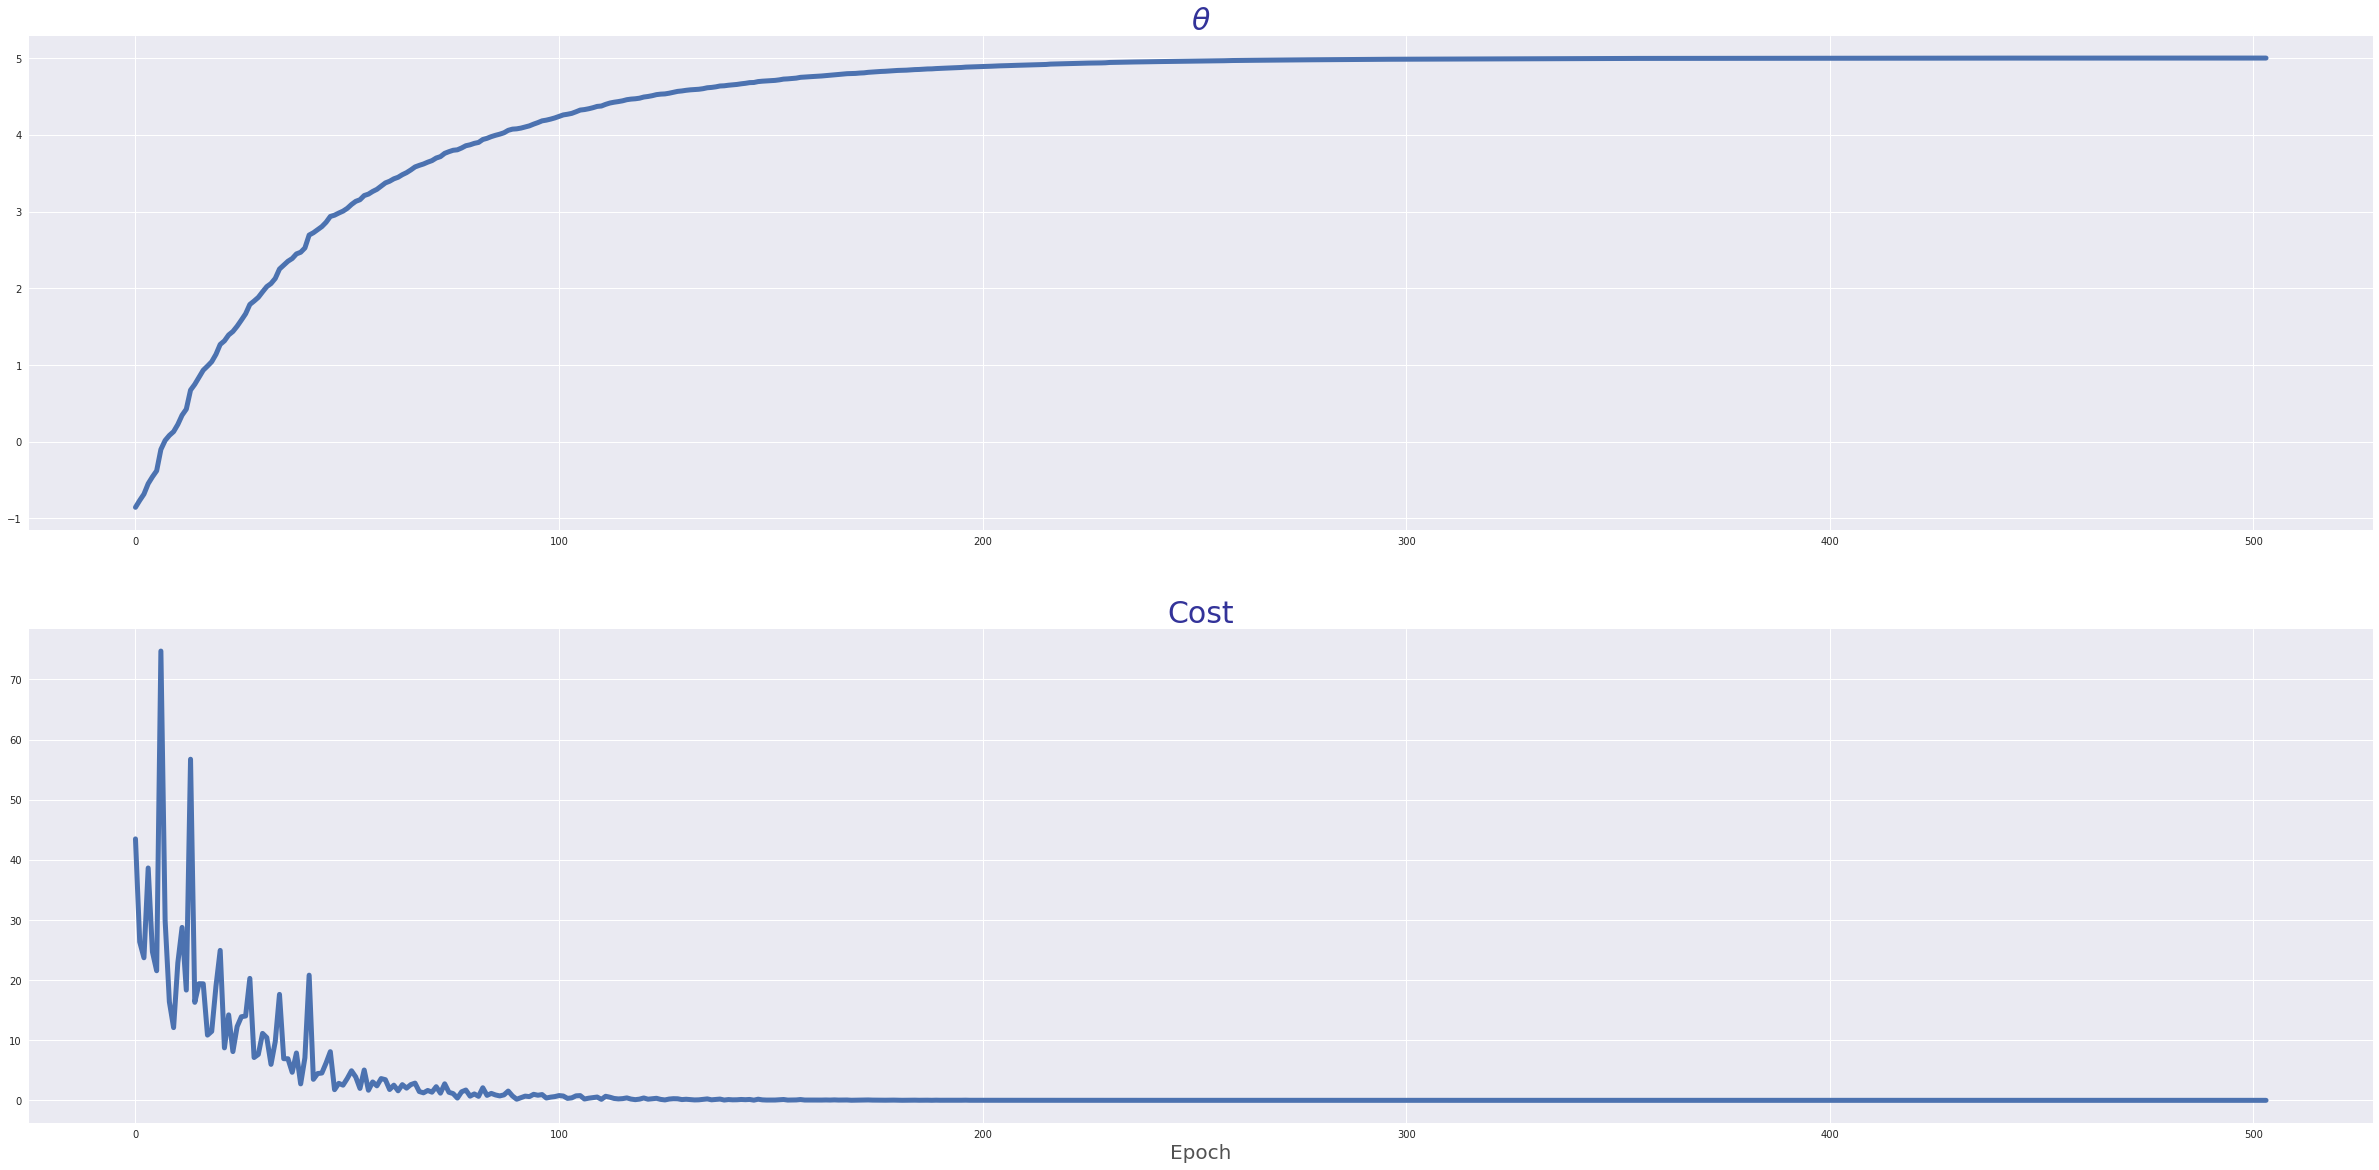

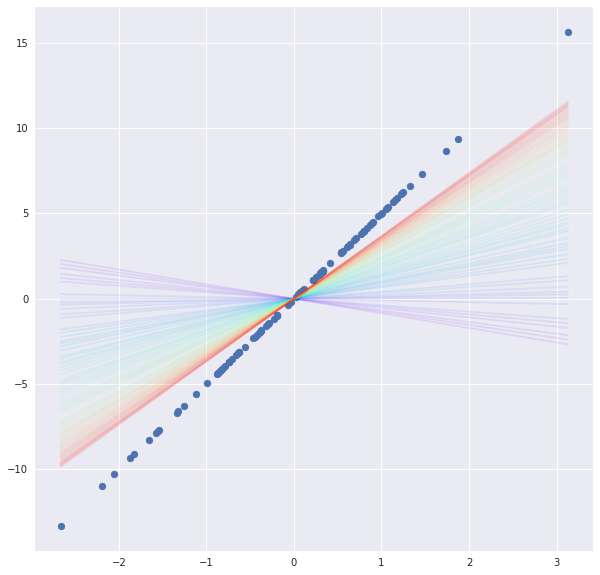

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class dataset_generator: 
    def __init__(self, feature_dim = 1, n_sample = 100, noise = 0):
        self._feature_dim = feature_dim
        self._n_sample = n_sample
        self._noise = noise
        
        self._coefficient = None
        self._init_set_coefficient()
        
    def _init_set_coefficient(self): 
        self._coefficient = [1 for _ in range(self._feature_dim)] + [0] 
        
    def set_n_sample(self, n_sample): #사용자가 접근할 수 있는 method
        self._n_sample = n_sample #n_sample을 default인 100이 아닌 사용자가 지정한 값으로 지정해줌
        
    def set_noise(self, noise): #사용자가 접근할 수 있는 method
        self._noise = noise
        
    def set_coefficient(self, coefficient_list): #사용자가 접근할 수 있는 method
        self._coefficient = coefficient_list
        
    def make_dataset(self):
        x_data = np.random.normal(0,1, size = (self._n_sample, self._feature_dim))
        y_data = np.zeros(shape = (self._n_sample, 1))
        for feature_idx in range(self._feature_dim):
            y_data += self._coefficient[feature_idx] * x_data[:,feature_idx].reshape(-1,1)
            y_data += self._coefficient[-1] #배열 맨 마지막인 bias를 더해줌
            y_data += self._noise * np.random.normal(0,1,size = (self._n_sample, 1))
        return x_data, y_data
    
    def dataset_visualizer(self):
        if self._feature_dim == 1:
            plt.style.use('seaborn')
            
            fig, ax = plt.subplots(figsize = (10,10))
            ax.plot(x_data, y_data, 'bo', alpha = 0.3, markersize = 20)
            ax.tick_params(axis = 'both', labelsize = 30)
            
            ax.set_title("DATASET", fontsize = 40, color = 'darkred')
            ax.set_xlabel("X Data", fontsize = 30, alpha = 0.6)
            ax.set_ylabel("Y Data", fontsize = 30, alpha = 0.6)
        else:
            class feature_dim_error(Exception):
                pass
            raise feature_dim_error("Visualization is valid for only feature_dim == 1.")

    
    
class plus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x + self._y
        return self._z
    
    def backward(self, dz):
        return dz, dz
    
class minus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x - self._y
        return self._z
    
    def backward(self, dz):
        return dz, -1*dz
    
class mul_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x * self._y
        return self._z
    
    def backward(self, dz):
        return dz*self._y, dz*self._x
    
class square_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = self._x * self._x
        return self._z
    
    def backward(self, dz):
        return dz*2*self._x
    
class mean_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = np.mean(self._x) 
        return self._z
    
    def backward(self, dz):
        dx = dz*1/len(self._x)*np.ones_like(self._x)
        return dx
    
    
dataset_gen = dataset_generator()
dataset_gen.set_coefficient([5,0])
x_data, y_data = dataset_gen.make_dataset()

# model part - prediction을 만들어줌
node1 = mul_node()

# square error and MSE cost part
node2 = minus_node()
node3 = square_node()
node4 = mean_node()

lr = 0.01 # learning rate setting
th = -1 # arbitrary theta

# for visualization
cost_list = []
th_list = []

batch_size = 16
n_batch = int(np.ceil(len(x_data)/batch_size))

t_iteration = 500
epochs = np.ceil(t_iteration/n_batch).astype(int)

for epoch in range(epochs):
    idx_np = np.arange(len(x_data))
    np.random.shuffle(idx_np)
    x_data = x_data[idx_np]
    y_data = y_data[idx_np]
    for batch_idx in range(n_batch):
        if batch_idx is n_batch-1:
            X = x_data[batch_idx*batch_size :]
            Y = y_data[batch_idx*batch_size :]
            
        else:
            X = x_data[batch_idx*batch_size : (batch_idx + 1)*batch_size]
            Y = y_data[batch_idx*batch_size : (batch_idx + 1)*batch_size]
    
        Z1 = node1.forward(th, X)
        Z2 = node2.forward(Y, Z1)
        L = node3.forward(Z2)
        J = node4.forward(L)
    
    
        dL = node4.backward(1)
        dZ2 = node3.backward(dL)
        dY, dZ1 = node2.backward(dZ2)
        dTh, dX = node1.backward(dZ1)
    
        th = th - lr*np.sum(dTh)
    
        # for visualization
        th_list.append(th)
        cost_list.append(J)
    
fig, ax = plt.subplots(2,1,figsize = (42,20))
ax[0].plot(th_list, linewidth = 5)
ax[1].plot(cost_list, linewidth = 5)

title_font = {'size':30, 'alpha':0.8, 'color': 'navy'}
label_font = {'size':20, 'alpha':0.8}
plt.style.use('seaborn')

ax[0].set_title(r'$\theta$', fontdict = title_font)
ax[1].set_title("Cost", fontdict = title_font)
ax[1].set_xlabel("Epoch", fontdict = label_font)


N_line = epochs
cmap = cm.get_cmap('rainbow', lut = N_line)

fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.scatter(x_data, y_data)

test_th = th_list[:N_line]
x_range = np.array([np.min(x_data), np.max(x_data)])

for line_idx in range(N_line):
    pred_line = np.array([x_range[0]*test_th[line_idx], x_range[1]*test_th[line_idx]])
    ax.plot(x_range, pred_line, color = cmap(line_idx), alpha = 0.1)
    


# Mini-batch Gradient Descent with Replacement

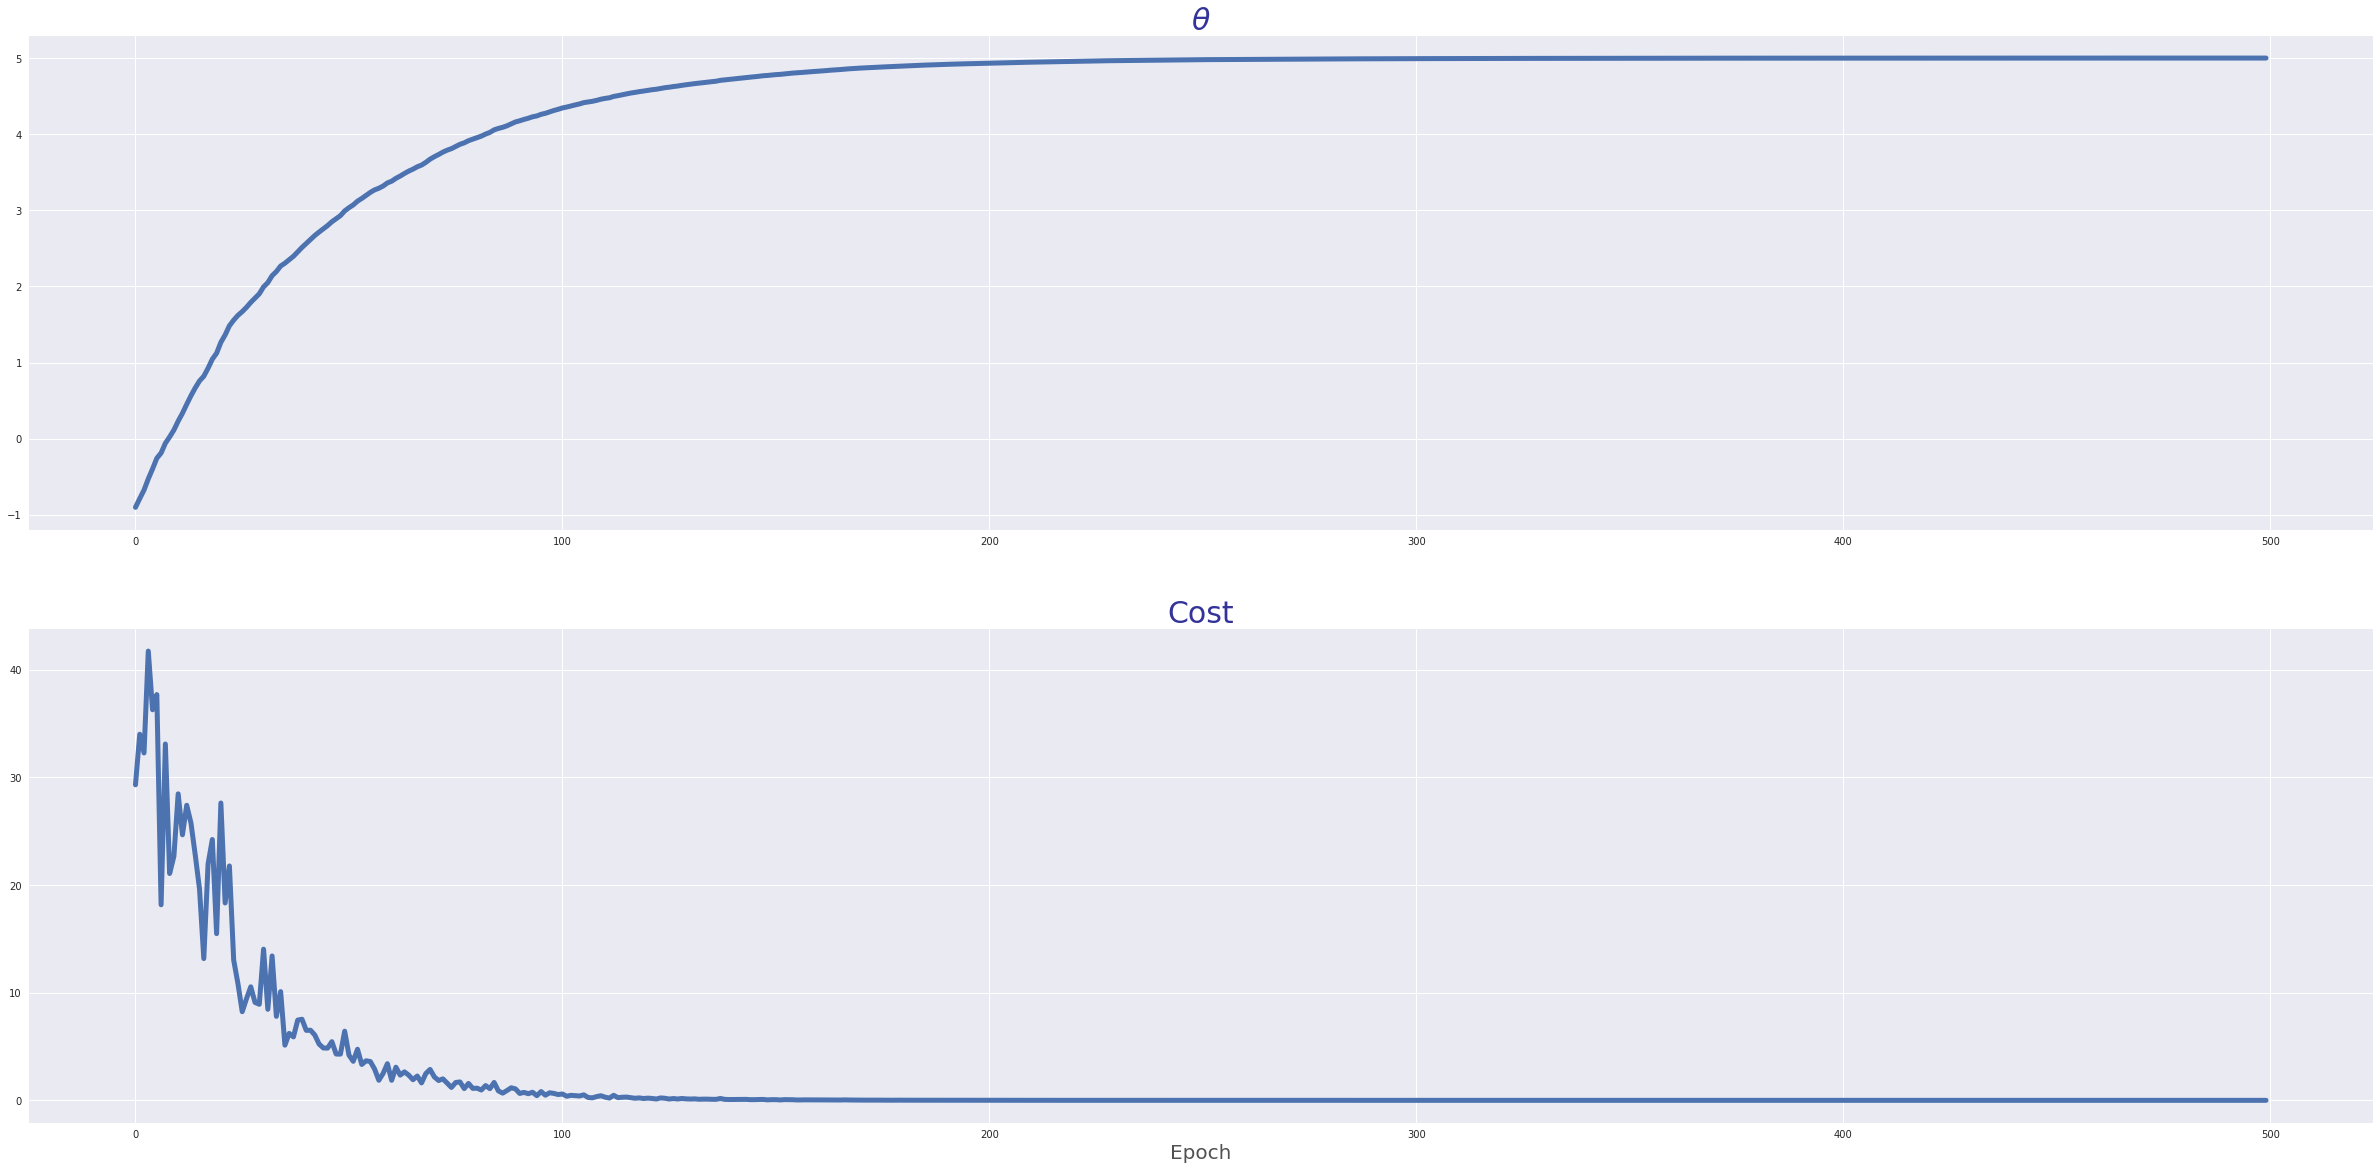

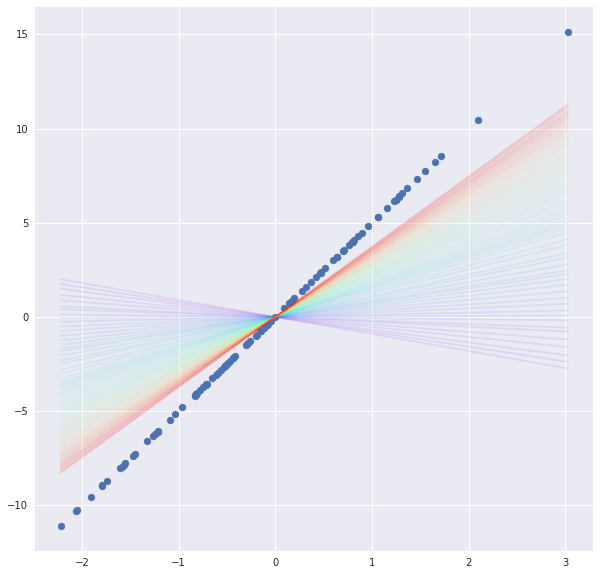

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class dataset_generator: 
    def __init__(self, feature_dim = 1, n_sample = 100, noise = 0):
        self._feature_dim = feature_dim
        self._n_sample = n_sample
        self._noise = noise
        
        self._coefficient = None
        self._init_set_coefficient()
        
    def _init_set_coefficient(self): 
        self._coefficient = [1 for _ in range(self._feature_dim)] + [0] 
        
    def set_n_sample(self, n_sample): #사용자가 접근할 수 있는 method
        self._n_sample = n_sample #n_sample을 default인 100이 아닌 사용자가 지정한 값으로 지정해줌
        
    def set_noise(self, noise): #사용자가 접근할 수 있는 method
        self._noise = noise
        
    def set_coefficient(self, coefficient_list): #사용자가 접근할 수 있는 method
        self._coefficient = coefficient_list
        
    def make_dataset(self):
        x_data = np.random.normal(0,1, size = (self._n_sample, self._feature_dim))
        y_data = np.zeros(shape = (self._n_sample, 1))
        for feature_idx in range(self._feature_dim):
            y_data += self._coefficient[feature_idx] * x_data[:,feature_idx].reshape(-1,1)
            y_data += self._coefficient[-1] #배열 맨 마지막인 bias를 더해줌
            y_data += self._noise * np.random.normal(0,1,size = (self._n_sample, 1))
        return x_data, y_data
    
    def dataset_visualizer(self):
        if self._feature_dim == 1:
            plt.style.use('seaborn')
            
            fig, ax = plt.subplots(figsize = (10,10))
            ax.plot(x_data, y_data, 'bo', alpha = 0.3, markersize = 20)
            ax.tick_params(axis = 'both', labelsize = 30)
            
            ax.set_title("DATASET", fontsize = 40, color = 'darkred')
            ax.set_xlabel("X Data", fontsize = 30, alpha = 0.6)
            ax.set_ylabel("Y Data", fontsize = 30, alpha = 0.6)
        else:
            class feature_dim_error(Exception):
                pass
            raise feature_dim_error("Visualization is valid for only feature_dim == 1.")

    
    
class plus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x + self._y
        return self._z
    
    def backward(self, dz):
        return dz, dz
    
class minus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x - self._y
        return self._z
    
    def backward(self, dz):
        return dz, -1*dz
    
class mul_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
        
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x * self._y
        return self._z
    
    def backward(self, dz):
        return dz*self._y, dz*self._x
    
class square_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = self._x * self._x
        return self._z
    
    def backward(self, dz):
        return dz*2*self._x
    
class mean_node:
    def __init__(self):
        self._x = None
        self._z = None
        
    def forward(self, x):
        self._x = x
        self._z = np.mean(self._x) 
        return self._z
    
    def backward(self, dz):
        dx = dz*1/len(self._x)*np.ones_like(self._x)
        return dx
    
    
dataset_gen = dataset_generator()
dataset_gen.set_coefficient([5,0])
x_data, y_data = dataset_gen.make_dataset()

# model part - prediction을 만들어줌
node1 = mul_node()

# square error and MSE cost part
node2 = minus_node()
node3 = square_node()
node4 = mean_node()

lr = 0.01 # learning rate setting
th = -1 # arbitrary theta

# for visualization
cost_list = []
th_list = []

batch_size = 32
t_iteration = 500

for _ in range(t_iteration):
    idx_np = np.arange(len(x_data))
    random_idx = np.random.choice(idx_np, batch_size)
    
    X = x_data[random_idx]
    Y = y_data[random_idx]
    
    Z1 = node1.forward(th, X)
    Z2 = node2.forward(Y, Z1)
    L = node3.forward(Z2)
    J = node4.forward(L)
    
    
    dL = node4.backward(1)
    dZ2 = node3.backward(dL)
    dY, dZ1 = node2.backward(dZ2)
    dTh, dX = node1.backward(dZ1)
    
    th = th - lr*np.sum(dTh)
    
    # for visualization
    th_list.append(th)
    cost_list.append(J)
    
fig, ax = plt.subplots(2,1,figsize = (42,20))
ax[0].plot(th_list, linewidth = 5)
ax[1].plot(cost_list, linewidth = 5)

title_font = {'size':30, 'alpha':0.8, 'color': 'navy'}
label_font = {'size':20, 'alpha':0.8}
plt.style.use('seaborn')

ax[0].set_title(r'$\theta$', fontdict = title_font)
ax[1].set_title("Cost", fontdict = title_font)
ax[1].set_xlabel("Epoch", fontdict = label_font)


N_line = epochs
cmap = cm.get_cmap('rainbow', lut = N_line)

fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.scatter(x_data, y_data)

test_th = th_list[:N_line]
x_range = np.array([np.min(x_data), np.max(x_data)])

for line_idx in range(N_line):
    pred_line = np.array([x_range[0]*test_th[line_idx], x_range[1]*test_th[line_idx]])
    ax.plot(x_range, pred_line, color = cmap(line_idx), alpha = 0.1)